In [1]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[1])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import scipy
import pickle
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import seaborn as sns
import sigpy as sp
import cupy as cp
import numpy as np
from sigpy.mri.app import TotalVariationRecon, L1WaveletRecon
from scipy.io import savemat
import twixtools
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.signal import butter,filtfilt


## My files
from resp_signal_functions import resp_signal_all_slices, resp_signal_single_slice, resp_signal_center_sample_single_slice
from resp_signal_plot_functions import *
import gating_functions
import gating_visuals
import save_data_helpers
import recon_plot_helpers

In [2]:
idx_amp_all, resp_trimmed_amp_all, data_bins_amp_all, spoke_bins_amp_all, index_bins_amp_all = save_data_helpers.load_gate_outputs_pickle('gates_amp_all_slices.pkl')

Loaded gates_amp_all_slices.pkl
  idx shape: (113116,)
  signal_trimmed shape: (113116,)
  data_bins: 5 elements
  spoke_bins: 5 elements
  index_bins: 5 elements


### Initial Reconstruction (NUFFT)

In [2]:
### Initial Reconstruction (NUFFT)
from sigpy.mri import dcf

def nufft_recon_ungated(data, coords):
    img_shape = (58, 256, 256)

    dcf_ksp = dcf.pipe_menon_dcf(coords, img_shape)
    img_grid = sp.nufft_adjoint(data * dcf_ksp, coords)

    ## Save arrays

    return dcf_ksp, img_grid

def nufft_recon_all_gates(data_bins, spoke_bins, gates_to_reconstruct):
    img_shape = (58, 256, 256)
    gated_dcfs = []
    gated_images = []
    for gate in gates_to_reconstruct:
        kspace_gate = data_bins[gate]  # Shape: (coils, spokes, partitions, samples)
        coords_gate = spoke_bins[gate]  # Shape: (spokes, partitions, samples, 3)
        dcf_ksp = dcf.pipe_menon_dcf(coords_gate, img_shape)
        img_grid = sp.nufft_adjoint(kspace_gate * dcf_ksp, coords_gate)

        ## Save arrays
        gated_dcfs.append(dcf_ksp)
        gated_images.append(img_grid)

    return gated_dcfs, gated_images

In [3]:
from gating_functions import golden_angle_coords_3d
from raw_data_utils import get_kspace_data
data_file_pt2 = '/data/lilianae/NaF_Patient2/anon_meas_MID00082_FID64646_Tho_fl3d_star_vibe_991_nav_tj_2000sp_AllCoils_SOS_2.dat'
# data_file_pt1 = '/data/lilianae/NaF_MtSinai/anon_meas_MID00118_FID60738_Tho_fl3d_star_vibe_991_nav_tj_2000sp_AllCoils_SOS.dat'

multi_twix, mapped, ksp_data = get_kspace_data(data_file_pt2)

coords = golden_angle_coords_3d((58, 256, 256), num_spokes=2002, num_points=256)
dcf_ksp, img_grid = nufft_recon_ungated(ksp_data, coords)

Software version: VD/VE (!?)

Scan  0


100%|██████████| 15.9G/15.9G [00:12<00:00, 1.33GB/s]


Full number of partitions = 72
ksp_data.shape = (15, 58, 2002, 256)


PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
save_data_helpers.write_pickle(dcf_ksp, 'ungated_dcf_mid0082.pkl')

Successfully saved as ungated_dcf_mid0082.pkl


In [4]:
gated_dcfs_amp_all, gated_images_amp_all = nufft_recon_all_gates(data_bins_amp_all,
                                                                 spoke_bins_amp_all,
                                                                 gates_to_reconstruct=[1, 2, 3])

PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# save_data_helpers.write_pickle(gated_dcfs_amp_all, 'gated_dcfs_amp_all_gates123.pkl')

Successfully saved as gated_dcfs_amp_all_gates123.pkl


In [ ]:
# save_data_helpers.write_pickle(gated_images_amp_all, 'gated_images_amp_all_gates123.pkl')

Successfully saved as gated_images_amp_all_gates123.pkl


In [6]:
def rss_recon(img_grid, plot=True, title=""):
    all_coil_imgs = np.stack(img_grid, axis=0)
    img_rss = np.sqrt(np.sum(np.abs(all_coil_imgs)**2, axis=0))
    Nz, Ny, Nx = img_rss.shape
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(15, 5))
        aspect = 58/256
        ax[0].imshow(img_rss[Nz//2, :, :], cmap='gray', aspect=1.)
        ax[1].imshow(np.rot90(img_rss[:, Ny//2, :], k=-3), cmap='gray', aspect=aspect)
        ax[2].imshow(np.rot90(img_rss[:, :, Nx//2], k=-1), cmap='gray', aspect=aspect)
        fig.suptitle(f"{title}")
        plt.show()
    return img_rss

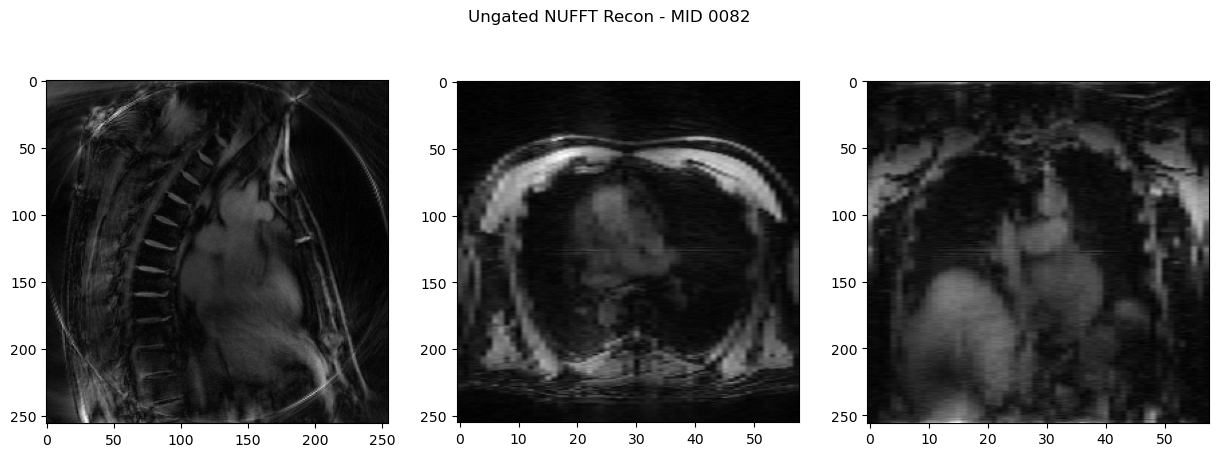

array([[[1.84613538e-23, 1.99507484e-23, 1.85981046e-23, ...,
         1.90916387e-23, 2.02910456e-23, 2.27329770e-23],
        [1.80800829e-23, 1.30447311e-23, 1.59418648e-23, ...,
         2.53170060e-23, 2.15961034e-23, 2.56118451e-23],
        [1.75665846e-23, 1.71893899e-23, 1.70251981e-23, ...,
         2.16850632e-23, 2.02012203e-23, 2.51873997e-23],
        ...,
        [1.88666288e-23, 1.67967268e-23, 2.24075189e-23, ...,
         3.34300527e-23, 3.81382620e-23, 3.53671651e-23],
        [2.58009443e-23, 2.38111186e-23, 2.46078934e-23, ...,
         3.59691236e-23, 3.40680471e-23, 3.22061863e-23],
        [2.92733362e-23, 2.35351174e-23, 2.17140989e-23, ...,
         3.03730219e-23, 3.21746529e-23, 4.05900812e-23]],

       [[2.58517994e-23, 2.57776119e-23, 2.11066968e-23, ...,
         2.86020395e-23, 2.94717278e-23, 2.52334394e-23],
        [2.19961470e-23, 1.67781067e-23, 2.01857202e-23, ...,
         2.79791056e-23, 2.50238434e-23, 3.04007760e-23],
        [2.08161868e-23, 

In [8]:
rss_recon(img_grid, title="Ungated NUFFT Recon - MID 0082")

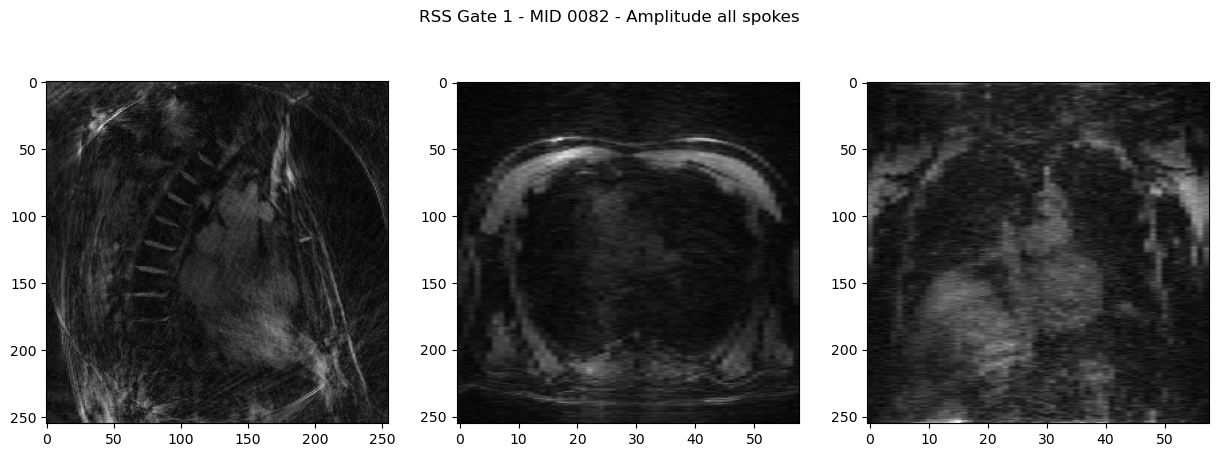

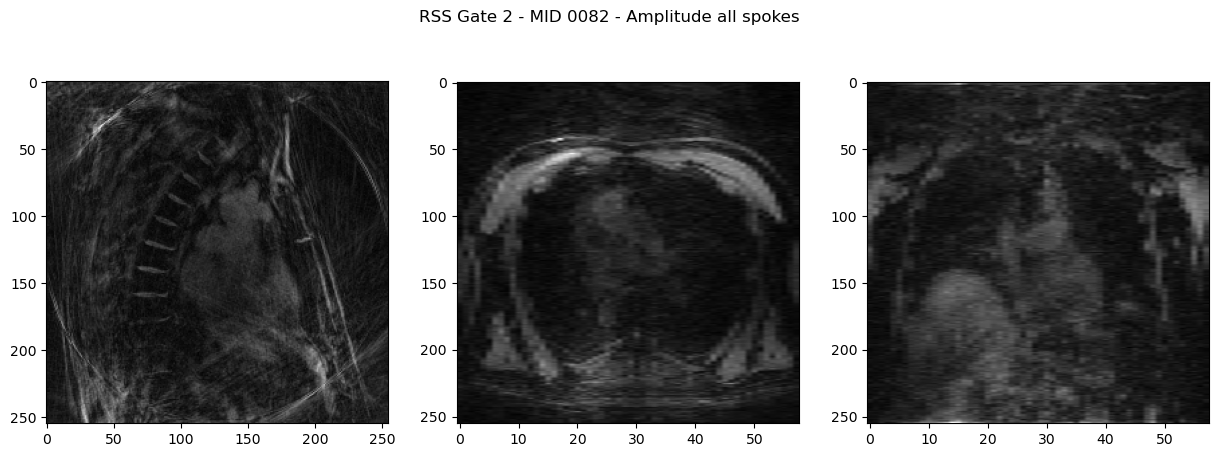

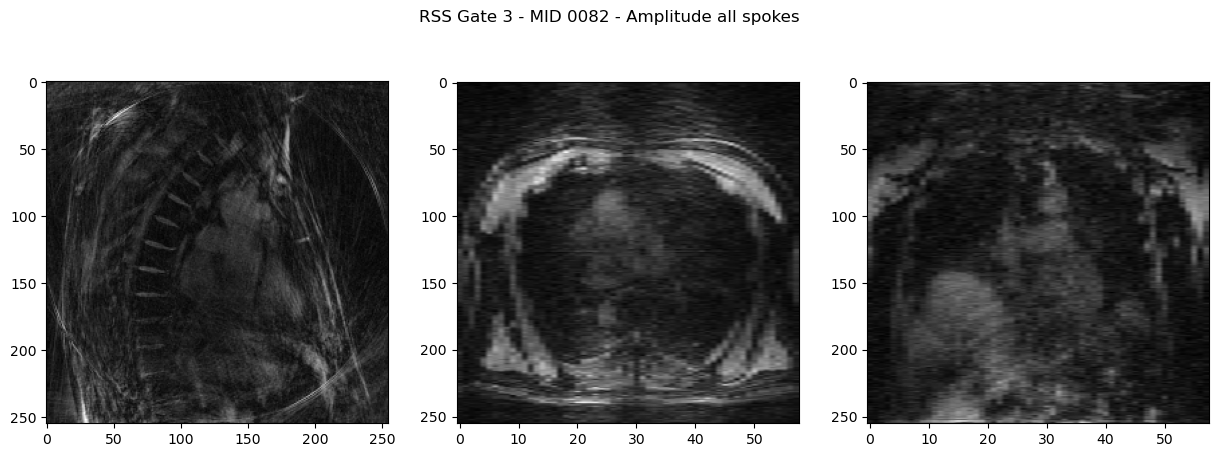

In [8]:
rss1 = rss_recon(gated_images_amp_all[0], title="RSS Gate 1 - MID 0082 - Amplitude all spokes")
rss2 = rss_recon(gated_images_amp_all[1], title="RSS Gate 2 - MID 0082 - Amplitude all spokes")
rss3 = rss_recon(gated_images_amp_all[2], title="RSS Gate 3 - MID 0082 - Amplitude all spokes")

In [9]:
gated_images_gates04 = save_data_helpers.read_pickle('gated_images_amp_gates04.pkl')
print(len(gated_images_gates04))

2


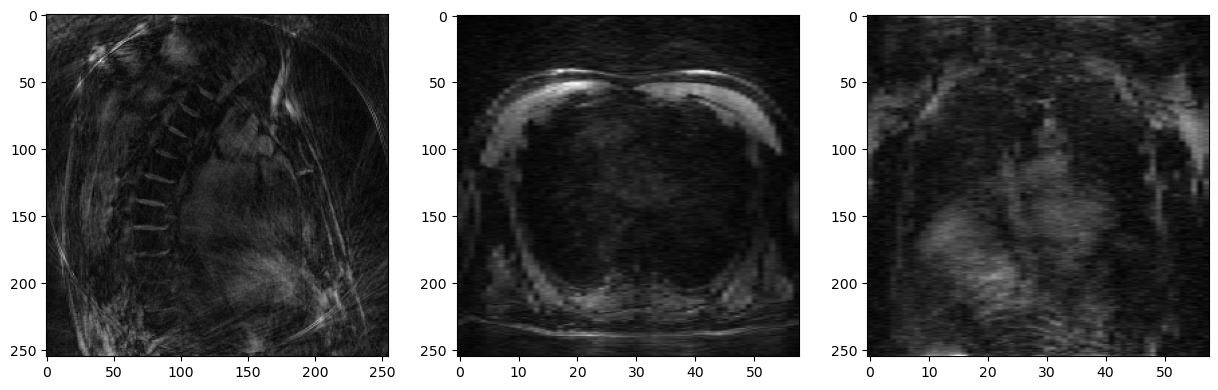

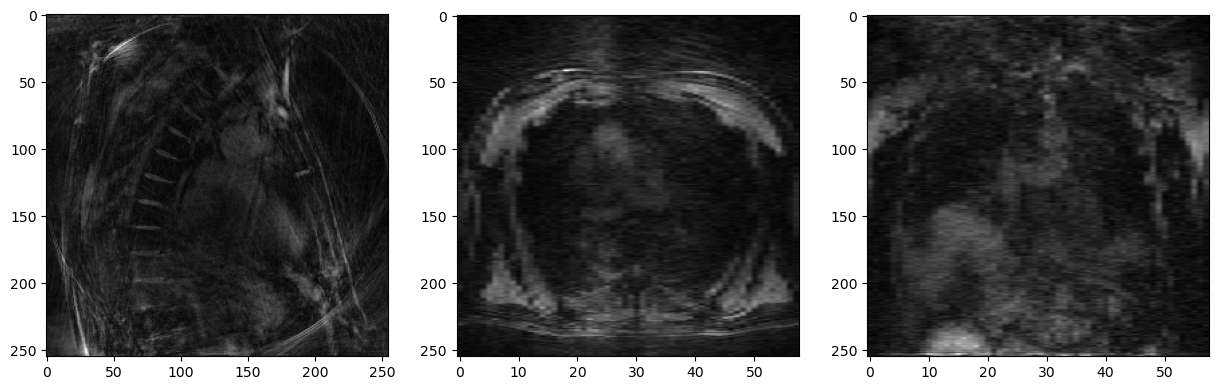

In [10]:
rss0 = rss_recon(gated_images_gates04[0])
rss4 = rss_recon(gated_images_gates04[1])

In [13]:
recon_plot_helpers.make_gif([rss0, rss1, rss2, rss3, rss4], slice_axis=0, gif_name="saggital_amp_all_5gates_dur100", duration=100.0)

GIF saved as saggital_amp_all_5gates_dur100.gif
